In [1]:
!git clone https://github.com/odashi/small_parallel_enja.git

Cloning into 'small_parallel_enja'...
remote: Enumerating objects: 35, done.
remote: Total 35 (delta 0), reused 0 (delta 0), pack-reused 35
Unpacking objects: 100% (35/35), done.


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [4]:
ls small_parallel_enja/

dev.en     train.en.000       train.en.vocab.all  train.ja.004
dev.ja     train.en.001       train.ja            train.ja.vocab.4k
README.md  train.en.002       train.ja.000        train.ja.vocab.all
test.en    train.en.003       train.ja.001
test.ja    train.en.004       train.ja.002
train.en   train.en.vocab.4k  train.ja.003


In [5]:
def Preprocess(text):
  text = "<start> "+text+" <end>"
  text = text.replace("\n", " ")
  text = re.sub(r"[' ']+", " ", text)
  return text

def Read(filename):
  new_lines = []
  with open(filename, "r") as f:
    lines = f.readlines()
  for line in lines:
    new_lines.append(Preprocess(line))
  return new_lines

def BuildTokenizer(texts):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='\n', oov_token="<unk>")
  tokenizer.fit_on_texts(texts)
  return tokenizer

def Texts2Sequences(tok, train_texts, valid_texts, test_texts):
  train_sequences = tok.texts_to_sequences(train_texts)
  valid_sequences = tok.texts_to_sequences(valid_texts)
  test_sequences = tok.texts_to_sequences(test_texts)
  
  padded_train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding="post")

  return padded_train_sequences, valid_sequences, test_sequences 

In [6]:
DIR_NAME = "small_parallel_enja/"
train_ja = Read(DIR_NAME+"train.ja")
train_en = Read(DIR_NAME+"train.en")

valid_ja = Read(DIR_NAME+"dev.ja")
valid_en = Read(DIR_NAME+"dev.en")

test_ja = Read(DIR_NAME+"test.ja")
test_en = Read(DIR_NAME+"train.en")

In [7]:
ja_tokenizer = BuildTokenizer(train_ja)
en_tokenizer = BuildTokenizer(train_en)

In [8]:
train_ja_sequences, valid_ja_sequences, test_ja_sequences = Texts2Sequences(ja_tokenizer, train_ja, valid_ja, test_ja)
train_en_sequences, valid_en_sequences, test_en_sequences = Texts2Sequences(en_tokenizer, train_en, valid_en, test_en)

In [9]:
def CreateEncoderModel(vocab_size):
  units = 128
  emb_layer = tf.keras.layers.Embedding(vocab_size, units, mask_zero=True, name="encdoder_emb")#padding有効にするために、mask_zero=True
  gru_layer  = tf.keras.layers.GRU(units, name="encdoder_gru")
  encoder_inputs = tf.keras.Input(shape=(None,), name="encdoder_inputs")
  outputs = emb_layer(encoder_inputs)
  outputs = gru_layer(outputs)
  
  encoder = tf.keras.Model(encoder_inputs, outputs)

  return encoder

def CreateDecoderModel(vocab_size):
  units = 128

  emb_layer = tf.keras.layers.Embedding(vocab_size, units, mask_zero=True, name="decdoder_emb")#padding有効にするために、mask_zero=True
  gru_layer  = tf.keras.layers.GRU(units, return_sequences=True, name="decdoder_gru")
  dense_layer = tf.keras.layers.Dense(vocab_size, activation="softmax", name="decdoder_outputs")

  decoder_inputs  = tf.keras.Input(shape=(None,), name="decdoder_inputs")
  decoder_hidden_states = tf.keras.Input(shape=(None,), name="decoder_hidden_states")

  outputs = emb_layer(decoder_inputs)
  gru_outputs = gru_layer(outputs, initial_state=decoder_hidden_states)
  outputs = dense_layer(gru_outputs)

  decoder = tf.keras.Model([decoder_inputs, decoder_hidden_states], [outputs, gru_outputs])

  return decoder

def CreateModel(seed, ja_vocab_size, en_vocab_size):
  tf.random.set_seed(seed)
  encoder = CreateEncoderModel(ja_vocab_size)
  decoder = CreateDecoderModel(en_vocab_size)

  encoder_inputs = tf.keras.Input(shape=(None,))
  decoder_inputs = tf.keras.Input(shape=(None,))

  encoder_outputs = encoder(encoder_inputs)
  decoder_outputs, gru_outputs = decoder([decoder_inputs, encoder_outputs])
  
  model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                )
  return model, encoder, decoder

In [14]:
#評価方法はBLEU
def Evaluate(ja_texts, en_texts, encoder, decoder):
  score = 0.0
  for ja_text, en_text in zip(ja_texts, en_texts):
    predicted_text = Predict(ja_text, encoder, decoder)
    score += sentence_bleu([en_text.strip().split()], predicted_text.strip().split(), smoothing_function=SmoothingFunction().method4)
  return score/len(ja_texts)

def Predict(ja_text, encoder, decoder):
  #日本語文章が形態素解析されていない状態の場合は、MeCabを使ってください。
  #MeCabの使い方
  #m = MeCab.Tagger("-Owakati")
  #ja_text           = m.parse(ja_text).strip()
  
  sequence         = ja_tokenizer.texts_to_sequences([ja_text.strip()])
  sequence         = np.array(sequence)
  encoder_outputs = encoder(sequence)

  decoder_hidden_states = encoder_outputs
  decoder_inputs = np.array(en_tokenizer.texts_to_sequences([["<start>"]]))

  #20回で打ち切り
  ans = "<start>"
  for _ in range(20):
    prediction, decoder_hidden_states = decoder([decoder_inputs, tf.reshape(decoder_hidden_states, [1, -1])])
    prediction_id = tf.argmax(prediction, axis=-1)[0][0].numpy()
    word = en_tokenizer.sequences_to_texts([[prediction_id]])
    decoder_inputs = np.reshape(np.array(prediction_id), [-1, 1])
    ans += " "+word[0]
    if word[0]=="<end>":
      break
  return ans

In [15]:
bleu_scores = []
batch_size_list = [32, 64, 128]
for batch_size in batch_size_list:
  model, encoder, decoder = CreateModel(123, len(ja_tokenizer.word_index)+1, len(en_tokenizer.word_index)+1)
  model.fit([train_ja_sequences, train_en_sequences[:, :-1]], train_en_sequences[:, 1:], batch_size=batch_size, epochs=2)
  model.save(str(batch_size)+"model.h5")
  encoder.load_weights(str(batch_size)+"model.h5", by_name=True)
  decoder.load_weights(str(batch_size)+"model.h5", by_name=True)
  bleu_score = Evaluate(valid_ja, valid_en, encoder, decoder)
  bleu_scores.append(bleu_score)

Epoch 1/2
1563/1563 [==============================] - 353s 226ms/step - loss: 2.2159
Epoch 2/2
1563/1563 [==============================] - 352s 225ms/step - loss: 1.6634
Epoch 1/2
782/782 [==============================] - 330s 421ms/step - loss: 2.4581
Epoch 2/2
782/782 [==============================] - 329s 421ms/step - loss: 1.8768
Epoch 1/2
391/391 [==============================] - 308s 788ms/step - loss: 2.7507
Epoch 2/2
391/391 [==============================] - 308s 788ms/step - loss: 2.0693


Text(0, 0.5, 'BLEU')

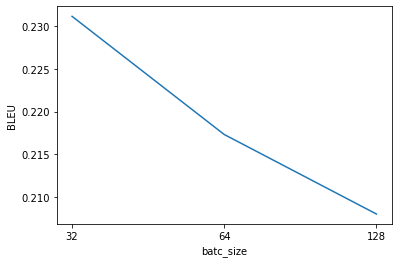

In [28]:
plt.plot([str(i) for i in batch_size_list], bleu_scores)
plt.xlabel("batch_size")
plt.ylabel("BLEU")

In [29]:
#学習データと検証データを混ぜる
valid_ja_sequences = tf.keras.preprocessing.sequence.pad_sequences(valid_ja_sequences, padding="post")
valid_en_sequences = tf.keras.preprocessing.sequence.pad_sequences(valid_en_sequences, padding="post")

train_and_valid_ja_sequences = tf.concat([train_ja_sequences, valid_ja_sequences], 0)
train_and_valid_en_sequences = tf.concat([train_en_sequences, valid_en_sequences], 0)

In [32]:
best_model, best_encoder, best_decoder = CreateModel(123, len(ja_tokenizer.word_index)+1, len(en_tokenizer.word_index)+1)
best_model.fit([train_and_valid_ja_sequences, train_and_valid_en_sequences[:, :-1]], train_and_valid_en_sequences[:, 1:], batch_size=32, epochs=10)
best_model.save("best_model.h5")

Epoch 1/10
1579/1579 [==============================] - 363s 230ms/step - loss: 2.2087
Epoch 2/10
1579/1579 [==============================] - 363s 230ms/step - loss: 1.6576
Epoch 3/10
1579/1579 [==============================] - 362s 229ms/step - loss: 1.4217
Epoch 4/10
1579/1579 [==============================] - 361s 229ms/step - loss: 1.2494
Epoch 5/10
1579/1579 [==============================] - 363s 230ms/step - loss: 1.1193
Epoch 6/10
1579/1579 [==============================] - 363s 230ms/step - loss: 1.0169
Epoch 7/10
1579/1579 [==============================] - 360s 228ms/step - loss: 0.9321
Epoch 8/10
1579/1579 [==============================] - 360s 228ms/step - loss: 0.8602
Epoch 9/10
1579/1579 [==============================] - 359s 227ms/step - loss: 0.7980
Epoch 10/10
1579/1579 [==============================] - 361s 228ms/step - loss: 0.7439


In [35]:
best_encoder.load_weights("best_model.h5", by_name=True)
best_decoder.load_weights("best_model.h5", by_name=True)
bleu_score = Evaluate(test_ja, test_en, best_encoder, best_decoder)
print("bleu on test_dataset:")
print(bleu_score)

bleu on test_dataset:
0.19258235343102567
